In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import os
%load_ext autoreload
%autoreload 2

In [2]:
function_df = pd.read_csv('Yap65/Yap65.csv')

In [3]:
function_df.head()

,protein,uniprot,sequence,predictions
0,Yap65,P46937,MDPGQQPPPQPAPQGQGQPPSQPPQGQGPPSGPGQPAPAATQAAPQ...,-0.074781
1,Yap65,P46937,MDPGQQPPPQPAPQGQGQPPSQPPQGQGPPSGPGQPAPAATQAAPQ...,0.017896
2,Yap65,P46937,MDPGQQPPPQPAPQGQGQPPSQPPQGQGPPSGPGQPAPAATQAAPQ...,0.070313
3,Yap65,P46937,MDPGQQPPPQPAPQGQGQPPSQPPQGQGPPSGPGQPAPAATQAAPQ...,0.076873
4,Yap65,P46937,MDPGQQPPPQPAPQGQGQPPSQPPQGQGPPSGPGQPAPAATQAAPQ...,0.086522


In [4]:
function_df['sequence_len'] = function_df['sequence'].apply(lambda seq: len(seq)) 
max_len = function_df['sequence_len'].max()

In [5]:
def sequence_to_aa(seq):
  return list(seq)

In [6]:
def get_sequence_aa(df):
  df['sequence_aa'] = df['sequence'].apply(lambda seq:sequence_to_aa(seq))
  df['length'] = df['sequence'].apply(lambda seq:len(seq))
  sequence_aa = np.array(df['sequence_aa'])
  return sequence_aa

In [7]:
sequence_aa = get_sequence_aa(function_df)

In [8]:
# import neccesary tools from Keras
import keras
from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical

Using TensorFlow backend.


In [9]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sequence_aa)
encoded = tokenizer.texts_to_sequences(sequence_aa)
vocab_len = len(tokenizer.word_index) + 1

In [10]:
X = np.array(encoded)
y = function_df['predictions']

from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.1)

In [11]:
y_train.mean()

0.8349884682835816

In [12]:
from keras.layers import Input, Dense, Embedding, LSTM, Bidirectional, Dropout, BatchNormalization, Softmax, multiply, Lambda, Flatten, Activation, RepeatVector, Permute, LeakyReLU
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.backend as K
from keras.optimizers import Adam, RMSprop
from keras.initializers import Constant

# from fit_one_cycle.clr import LRFinder

In [13]:
LSTM_size = 10
dense_sizes = [16]
LSTM_dropout = 0.0
n_epochs = 1000
adam_lr = [0.001, 0.003]
initializers = ['he_uniform']

In [14]:
def get_model_LSTM(initializer, LSTM_size):
    input = Input(shape = [max_len])
    embedding = Embedding(input_dim = vocab_len, 
                          output_dim = 20, 
                          input_length = max_len, 
                          trainable = True)(input)

    activations = LSTM(LSTM_size,
                       dropout = LSTM_dropout,
                       kernel_initializer = initializer)(embedding)

    sequence_representation = Dense(64, kernel_initializer = initializer)(activations)
    sequence_representation = LeakyReLU()(sequence_representation)
    # sequence_representation = Dropout(0.2)(sequence_representation)
    sequence_representation = Dense(32, kernel_initializer = initializer)(sequence_representation)
    sequence_representation = LeakyReLU()(sequence_representation)
    # sequence_representation = Dropout(0.2)(sequence_representation)

    output = Dense(1, bias_initializer = Constant(y_train.mean()))(sequence_representation)

    model = Model(inputs = [input], outputs = output)
    return model

In [15]:
def get_model_LSTM_attention(initializer, LSTM_size):
    input = Input(shape = [max_len])
    embedding = Embedding(input_dim = vocab_len, 
                          output_dim = 20, 
                          input_length = max_len, 
                          trainable = True)(input)

    activations = LSTM(LSTM_size, return_sequences = True,
                       dropout = LSTM_dropout,
                       kernel_initializer = initializer)(embedding)

    attention = Dense(1, activation = 'tanh', kernel_initializer = initializer)(activations)
    attention = Flatten()(attention)
    attention = Activation('softmax', name = 'attention_activations')(attention)
    attention = RepeatVector(LSTM_size)(attention)
    attention = Permute([2, 1])(attention)

    sequence_representation = multiply([activations, attention])
    sequence_representation = Lambda(lambda xin: K.sum(xin, axis = -2), output_shape = (LSTM_size,))(sequence_representation)
    
    sequence_representation = Dense(64, kernel_initializer = initializer)(sequence_representation)
    sequence_representation = LeakyReLU()(sequence_representation)
    # sequence_representation = Dropout(0.2)(sequence_representation)
    sequence_representation = Dense(32, kernel_initializer = initializer)(sequence_representation)
    sequence_representation = LeakyReLU()(sequence_representation)
    # sequence_representation = Dropout(0.2)(sequence_representation)

    output = Dense(1, bias_initializer = Constant(y_train.mean()))(sequence_representation)

    model = Model(inputs = [input], outputs = output)
    return model

In [16]:
def get_model_biLSTM_attention(initializer, LSTM_size):
    input = Input(shape = [max_len])
    embedding = Embedding(input_dim = vocab_len, 
                          output_dim = 20, 
                          input_length = max_len, 
                          trainable = True)(input)

    activations = Bidirectional(LSTM(LSTM_size, return_sequences = True,
                       dropout = LSTM_dropout,
                       kernel_initializer = initializer))(embedding)

    attention = Dense(1, activation = 'tanh', kernel_initializer = initializer)(activations)
    attention = Flatten()(attention)
    attention = Activation('softmax', name = 'attention_activations')(attention)
    attention = RepeatVector(LSTM_size * 2)(attention)
    attention = Permute([2, 1])(attention)

    sequence_representation = multiply([activations, attention])
    sequence_representation = Lambda(lambda xin: K.sum(xin, axis = -2), output_shape = (LSTM_size * 2,))(sequence_representation)
    
    sequence_representation = Dense(64, kernel_initializer = initializer)(sequence_representation)
    sequence_representation = LeakyReLU()(sequence_representation)
    # sequence_representation = Dropout(0.2)(sequence_representation)
    sequence_representation = Dense(32, kernel_initializer = initializer)(sequence_representation)
    sequence_representation = LeakyReLU()(sequence_representation)
    # sequence_representation = Dropout(0.2)(sequence_representation)

    output = Dense(1, bias_initializer = Constant(y_train.mean()))(sequence_representation)

    model = Model(inputs = [input], outputs = output)
    return model

adam_lr - 0.001 initializer - he_uniform
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 268 samples, validate on 30 samples
Epoch 1/1000
268/268 [==============================] - 6s 22ms/step - loss: 0.0768 - val_loss: 0.0559
Epoch 2/1000
268/268 [==============================] - 1s 2ms/step - loss: 0.0769 - val_loss: 0.0566
Epoch 3/1000
268/268 [==============================] - 1s 2ms/step - loss: 0.0767 - val_loss: 0.0581
Epoch 4/1000
268/268 [==============================] - 1s 2ms/step - loss: 0.0766 - val_loss: 0.0596
Epoch 5/1000
268/268 [==============================] - 1s 2ms/step - loss: 0.0767 - val_loss: 0.0599
Epoch 6/1000
268/268 [==============================] - 1s 2ms/step - loss: 0.0767 - val_loss: 0.0595
Epoch 7/1000
268/268 [==============================] - 1s 2ms/step - loss: 0.0767 - val_loss: 0.0586
Epoch 8/1000
268/268 [==============================] - 1s 2ms/step - loss: 0.0

Epoch 75/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0765 - val_loss: 0.0602
Epoch 76/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0764 - val_loss: 0.0585
Epoch 77/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0762 - val_loss: 0.0558
Epoch 78/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0764 - val_loss: 0.0580
Epoch 79/1000
268/268 [==============================] - 1s 2ms/step - loss: 0.0761 - val_loss: 0.0601
Epoch 80/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0763 - val_loss: 0.0571
Epoch 81/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0761 - val_loss: 0.0561
Epoch 82/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0762 - val_loss: 0.0587
Epoch 83/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0761 - val_loss: 0.0593
Epoch 84/1000
268/268 [==============================] - 0s 2ms/step - lo

268/268 [==============================] - 0s 2ms/step - loss: 0.0707 - val_loss: 0.1027
Epoch 155/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0981 - val_loss: 0.0702
Epoch 156/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0772 - val_loss: 0.0533
Epoch 157/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0890 - val_loss: 0.0565
Epoch 158/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0954 - val_loss: 0.0520
Epoch 159/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0844 - val_loss: 0.0522
Epoch 160/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0741 - val_loss: 0.0681
Epoch 161/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0776 - val_loss: 0.0759
Epoch 162/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0818 - val_loss: 0.0736
Epoch 163/1000
268/268 [==============================] - 0s 2ms/step - loss: 0

Epoch 233/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0750 - val_loss: 0.0566
Epoch 234/1000
268/268 [==============================] - 1s 2ms/step - loss: 0.0749 - val_loss: 0.0565
Epoch 235/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0749 - val_loss: 0.0565
Epoch 236/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0749 - val_loss: 0.0565
Epoch 237/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0748 - val_loss: 0.0565
Epoch 238/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0748 - val_loss: 0.0565
Epoch 239/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0747 - val_loss: 0.0565
Epoch 240/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0747 - val_loss: 0.0564
Epoch 241/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0747 - val_loss: 0.0564
Epoch 242/1000
268/268 [==============================] - 1s 2ms

Epoch 312/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0758 - val_loss: 0.0583
Epoch 313/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0758 - val_loss: 0.0587
Epoch 314/1000
268/268 [==============================] - 1s 2ms/step - loss: 0.0759 - val_loss: 0.0591
Epoch 315/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0759 - val_loss: 0.0594
Epoch 316/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0760 - val_loss: 0.0595
Epoch 317/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0760 - val_loss: 0.0596
Epoch 318/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0760 - val_loss: 0.0595
Epoch 319/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0759 - val_loss: 0.0593
Epoch 320/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0759 - val_loss: 0.0590
Epoch 321/1000
268/268 [==============================] - 0s 2ms

Epoch 391/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0752 - val_loss: 0.0570
Epoch 392/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0752 - val_loss: 0.0569
Epoch 393/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0752 - val_loss: 0.0569
Epoch 394/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0752 - val_loss: 0.0569
Epoch 395/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0752 - val_loss: 0.0569
Epoch 396/1000
268/268 [==============================] - 1s 2ms/step - loss: 0.0752 - val_loss: 0.0569
Epoch 397/1000
268/268 [==============================] - 1s 2ms/step - loss: 0.0751 - val_loss: 0.0569
Epoch 398/1000
268/268 [==============================] - 1s 2ms/step - loss: 0.0751 - val_loss: 0.0568
Epoch 399/1000
268/268 [==============================] - 1s 2ms/step - loss: 0.0751 - val_loss: 0.0568
Epoch 400/1000
268/268 [==============================] - 1s 2ms

Epoch 470/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0724 - val_loss: 0.0543
Epoch 471/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0723 - val_loss: 0.0542
Epoch 472/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0721 - val_loss: 0.0541
Epoch 473/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0720 - val_loss: 0.0539
Epoch 474/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0718 - val_loss: 0.0536
Epoch 475/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0716 - val_loss: 0.0535
Epoch 476/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0714 - val_loss: 0.0534
Epoch 477/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0712 - val_loss: 0.0533
Epoch 478/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0710 - val_loss: 0.0530
Epoch 479/1000
268/268 [==============================] - 0s 2ms

Epoch 549/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0763 - val_loss: 0.0576
Epoch 550/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0762 - val_loss: 0.0577
Epoch 551/1000
268/268 [==============================] - 1s 2ms/step - loss: 0.0762 - val_loss: 0.0579
Epoch 552/1000
268/268 [==============================] - 1s 2ms/step - loss: 0.0762 - val_loss: 0.0580
Epoch 553/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0762 - val_loss: 0.0581
Epoch 554/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0762 - val_loss: 0.0582
Epoch 555/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0762 - val_loss: 0.0583
Epoch 556/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0762 - val_loss: 0.0584
Epoch 557/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0763 - val_loss: 0.0584
Epoch 558/1000
268/268 [==============================] - 0s 2ms

Epoch 628/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0762 - val_loss: 0.0579
Epoch 629/1000
268/268 [==============================] - 1s 2ms/step - loss: 0.0762 - val_loss: 0.0579
Epoch 630/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0762 - val_loss: 0.0579
Epoch 631/1000
268/268 [==============================] - 1s 2ms/step - loss: 0.0762 - val_loss: 0.0579
Epoch 632/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0762 - val_loss: 0.0579
Epoch 633/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0762 - val_loss: 0.0579
Epoch 634/1000
268/268 [==============================] - 1s 2ms/step - loss: 0.0762 - val_loss: 0.0579
Epoch 635/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0762 - val_loss: 0.0579
Epoch 636/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0762 - val_loss: 0.0579
Epoch 637/1000
268/268 [==============================] - 0s 2ms

Epoch 707/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0762 - val_loss: 0.0578
Epoch 708/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0762 - val_loss: 0.0578
Epoch 709/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0762 - val_loss: 0.0578
Epoch 710/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0762 - val_loss: 0.0578
Epoch 711/1000
268/268 [==============================] - 1s 2ms/step - loss: 0.0762 - val_loss: 0.0578
Epoch 712/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0762 - val_loss: 0.0578
Epoch 713/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0762 - val_loss: 0.0578
Epoch 714/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0762 - val_loss: 0.0578
Epoch 715/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0762 - val_loss: 0.0578
Epoch 716/1000
268/268 [==============================] - 0s 2ms

Epoch 786/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0762 - val_loss: 0.0578
Epoch 787/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0762 - val_loss: 0.0578
Epoch 788/1000
268/268 [==============================] - 1s 2ms/step - loss: 0.0762 - val_loss: 0.0578
Epoch 789/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0762 - val_loss: 0.0578
Epoch 790/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0762 - val_loss: 0.0578
Epoch 791/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0762 - val_loss: 0.0578
Epoch 792/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0762 - val_loss: 0.0578
Epoch 793/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0762 - val_loss: 0.0578
Epoch 794/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0762 - val_loss: 0.0578
Epoch 795/1000
268/268 [==============================] - 0s 2ms

Epoch 865/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0761 - val_loss: 0.0578
Epoch 866/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0761 - val_loss: 0.0578
Epoch 867/1000
268/268 [==============================] - 1s 2ms/step - loss: 0.0761 - val_loss: 0.0578
Epoch 868/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0761 - val_loss: 0.0578
Epoch 869/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0761 - val_loss: 0.0578
Epoch 870/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0761 - val_loss: 0.0578
Epoch 871/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0761 - val_loss: 0.0578
Epoch 872/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0761 - val_loss: 0.0578
Epoch 873/1000
268/268 [==============================] - 1s 2ms/step - loss: 0.0761 - val_loss: 0.0578
Epoch 874/1000
268/268 [==============================] - 1s 2ms

Epoch 944/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0761 - val_loss: 0.0578
Epoch 945/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0761 - val_loss: 0.0578
Epoch 946/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0761 - val_loss: 0.0578
Epoch 947/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0761 - val_loss: 0.0578
Epoch 948/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0761 - val_loss: 0.0578
Epoch 949/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0761 - val_loss: 0.0578
Epoch 950/1000
268/268 [==============================] - 1s 2ms/step - loss: 0.0761 - val_loss: 0.0578
Epoch 951/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0761 - val_loss: 0.0578
Epoch 952/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0761 - val_loss: 0.0578
Epoch 953/1000
268/268 [==============================] - 0s 2ms

Epoch 23/1000
268/268 [==============================] - 1s 2ms/step - loss: 0.0766 - val_loss: 0.0584
Epoch 24/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0766 - val_loss: 0.0587
Epoch 25/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0766 - val_loss: 0.0587
Epoch 26/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0766 - val_loss: 0.0585
Epoch 27/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0766 - val_loss: 0.0581
Epoch 28/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0766 - val_loss: 0.0578
Epoch 29/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0766 - val_loss: 0.0578
Epoch 30/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0766 - val_loss: 0.0580
Epoch 31/1000
268/268 [==============================] - 1s 2ms/step - loss: 0.0766 - val_loss: 0.0583
Epoch 32/1000
268/268 [==============================] - 0s 2ms/step - lo

Epoch 103/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0764 - val_loss: 0.0553
Epoch 104/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0767 - val_loss: 0.0576
Epoch 105/1000
268/268 [==============================] - 1s 2ms/step - loss: 0.0762 - val_loss: 0.0608
Epoch 106/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0766 - val_loss: 0.0578
Epoch 107/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0762 - val_loss: 0.0557
Epoch 108/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0765 - val_loss: 0.0583
Epoch 109/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0762 - val_loss: 0.0602
Epoch 110/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0764 - val_loss: 0.0570
Epoch 111/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0762 - val_loss: 0.0560
Epoch 112/1000
268/268 [==============================] - 0s 2ms

Epoch 182/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0762 - val_loss: 0.0578
Epoch 183/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0762 - val_loss: 0.0576
Epoch 184/1000
268/268 [==============================] - 1s 2ms/step - loss: 0.0762 - val_loss: 0.0575
Epoch 185/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0762 - val_loss: 0.0575
Epoch 186/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0762 - val_loss: 0.0576
Epoch 187/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0762 - val_loss: 0.0578
Epoch 188/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0762 - val_loss: 0.0579
Epoch 189/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0762 - val_loss: 0.0580
Epoch 190/1000
268/268 [==============================] - 1s 2ms/step - loss: 0.0762 - val_loss: 0.0580
Epoch 191/1000
268/268 [==============================] - 0s 2ms

Epoch 261/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0765 - val_loss: 0.0589
Epoch 262/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0765 - val_loss: 0.0584
Epoch 263/1000
268/268 [==============================] - 1s 2ms/step - loss: 0.0765 - val_loss: 0.0580
Epoch 264/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0764 - val_loss: 0.0576
Epoch 265/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0765 - val_loss: 0.0574
Epoch 266/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0765 - val_loss: 0.0572
Epoch 267/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0765 - val_loss: 0.0571
Epoch 268/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0765 - val_loss: 0.0572
Epoch 269/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0765 - val_loss: 0.0573
Epoch 270/1000
268/268 [==============================] - 0s 2ms

Epoch 340/1000
268/268 [==============================] - 1s 2ms/step - loss: 0.0761 - val_loss: 0.0577
Epoch 341/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0761 - val_loss: 0.0577
Epoch 342/1000
268/268 [==============================] - 1s 2ms/step - loss: 0.0761 - val_loss: 0.0577
Epoch 343/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0761 - val_loss: 0.0577
Epoch 344/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0761 - val_loss: 0.0577
Epoch 345/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0760 - val_loss: 0.0577
Epoch 346/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0760 - val_loss: 0.0577
Epoch 347/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0760 - val_loss: 0.0576
Epoch 348/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0760 - val_loss: 0.0576
Epoch 349/1000
268/268 [==============================] - 1s 2ms

Epoch 419/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0751 - val_loss: 0.0551
Epoch 420/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0752 - val_loss: 0.0543
Epoch 421/1000
268/268 [==============================] - 1s 2ms/step - loss: 0.0754 - val_loss: 0.0540
Epoch 422/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0755 - val_loss: 0.0542
Epoch 423/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0754 - val_loss: 0.0548
Epoch 424/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0751 - val_loss: 0.0559
Epoch 425/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0750 - val_loss: 0.0571
Epoch 426/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0750 - val_loss: 0.0580
Epoch 427/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0750 - val_loss: 0.0584
Epoch 428/1000
268/268 [==============================] - 0s 2ms

Epoch 498/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0768 - val_loss: 0.0586
Epoch 499/1000
268/268 [==============================] - 1s 2ms/step - loss: 0.0766 - val_loss: 0.0570
Epoch 500/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0767 - val_loss: 0.0558
Epoch 501/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0770 - val_loss: 0.0550
Epoch 502/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0773 - val_loss: 0.0545
Epoch 503/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0777 - val_loss: 0.0542
Epoch 504/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0780 - val_loss: 0.0541
Epoch 505/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0781 - val_loss: 0.0541
Epoch 506/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0781 - val_loss: 0.0542
Epoch 507/1000
268/268 [==============================] - 0s 2ms

Epoch 577/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0765 - val_loss: 0.0580
Epoch 578/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0765 - val_loss: 0.0580
Epoch 579/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0765 - val_loss: 0.0580
Epoch 580/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0765 - val_loss: 0.0580
Epoch 581/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0764 - val_loss: 0.0580
Epoch 582/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0764 - val_loss: 0.0581
Epoch 583/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0764 - val_loss: 0.0581
Epoch 584/1000
268/268 [==============================] - 1s 2ms/step - loss: 0.0764 - val_loss: 0.0581
Epoch 585/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0764 - val_loss: 0.0581
Epoch 586/1000
268/268 [==============================] - 1s 2ms

Epoch 656/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0763 - val_loss: 0.0579
Epoch 657/1000
268/268 [==============================] - 1s 2ms/step - loss: 0.0763 - val_loss: 0.0579
Epoch 658/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0763 - val_loss: 0.0579
Epoch 659/1000
268/268 [==============================] - 1s 2ms/step - loss: 0.0763 - val_loss: 0.0579
Epoch 660/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0763 - val_loss: 0.0579
Epoch 661/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0763 - val_loss: 0.0579
Epoch 662/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0763 - val_loss: 0.0579
Epoch 663/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0763 - val_loss: 0.0579
Epoch 664/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0763 - val_loss: 0.0579
Epoch 665/1000
268/268 [==============================] - 0s 2ms

Epoch 735/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0761 - val_loss: 0.0577
Epoch 736/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0761 - val_loss: 0.0577
Epoch 737/1000
268/268 [==============================] - 1s 2ms/step - loss: 0.0760 - val_loss: 0.0577
Epoch 738/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0760 - val_loss: 0.0576
Epoch 739/1000
268/268 [==============================] - 1s 2ms/step - loss: 0.0760 - val_loss: 0.0576
Epoch 740/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0760 - val_loss: 0.0576
Epoch 741/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0760 - val_loss: 0.0576
Epoch 742/1000
268/268 [==============================] - 1s 2ms/step - loss: 0.0760 - val_loss: 0.0576
Epoch 743/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0760 - val_loss: 0.0576
Epoch 744/1000
268/268 [==============================] - 0s 2ms

Epoch 814/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0754 - val_loss: 0.0571
Epoch 815/1000
268/268 [==============================] - 1s 2ms/step - loss: 0.0754 - val_loss: 0.0571
Epoch 816/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0754 - val_loss: 0.0570
Epoch 817/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0754 - val_loss: 0.0570
Epoch 818/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0753 - val_loss: 0.0570
Epoch 819/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0753 - val_loss: 0.0570
Epoch 820/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0753 - val_loss: 0.0570
Epoch 821/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0753 - val_loss: 0.0570
Epoch 822/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0753 - val_loss: 0.0569
Epoch 823/1000
268/268 [==============================] - 0s 2ms

Epoch 893/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0685 - val_loss: 0.0519
Epoch 894/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0681 - val_loss: 0.0511
Epoch 895/1000
268/268 [==============================] - 1s 2ms/step - loss: 0.0677 - val_loss: 0.0511
Epoch 896/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0673 - val_loss: 0.0512
Epoch 897/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0669 - val_loss: 0.0504
Epoch 898/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0666 - val_loss: 0.0507
Epoch 899/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0662 - val_loss: 0.0508
Epoch 900/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0659 - val_loss: 0.0501
Epoch 901/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0656 - val_loss: 0.0508
Epoch 902/1000
268/268 [==============================] - 0s 2ms

Epoch 972/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0613 - val_loss: 0.0534
Epoch 973/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0613 - val_loss: 0.0547
Epoch 974/1000
268/268 [==============================] - 1s 2ms/step - loss: 0.0612 - val_loss: 0.0546
Epoch 975/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0612 - val_loss: 0.0537
Epoch 976/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0611 - val_loss: 0.0550
Epoch 977/1000
268/268 [==============================] - 1s 2ms/step - loss: 0.0611 - val_loss: 0.0545
Epoch 978/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0610 - val_loss: 0.0540
Epoch 979/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0609 - val_loss: 0.0551
Epoch 980/1000
268/268 [==============================] - 0s 2ms/step - loss: 0.0609 - val_loss: 0.0543
Epoch 981/1000
268/268 [==============================] - 0s 2ms

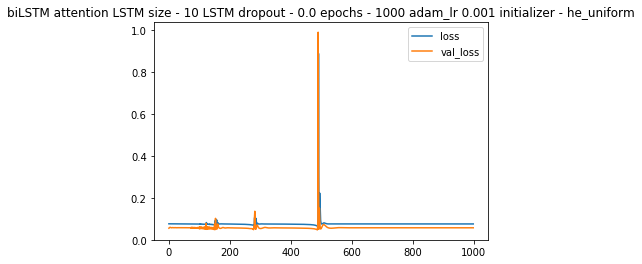

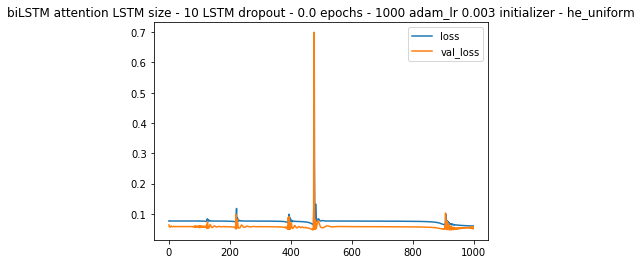

In [17]:
for i in range(len(adam_lr)):
    lr = adam_lr[i]
    for j in range(len(initializers)):
        initializer = initializers[j]
        print(f'adam_lr - {lr} initializer - {initializer}')

        optimizer = Adam(lr = lr)
        model = get_model_biLSTM_attention(initializer, LSTM_size)
        model.compile(optimizer = optimizer,
                     loss = 'mean_squared_error')
        # early_stopping = EarlyStopping(patience = 300)

        folder_path = 'Yap65/model_and_checkpoints/' + f'biLSTM attention LSTM size - {LSTM_size} epochs - {n_epochs} adam_lr {lr} initializer - {initializer}'
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        checkpointing = ModelCheckpoint(folder_path + '/weights.{epoch:02d}-{val_loss:.5f}.hdf5',
                               save_best_only = True)
        history = model.fit(X_train, y_train, validation_data = (X_val, y_val), 
                            batch_size = 268, epochs = n_epochs, verbose = 1,
                            callbacks = [checkpointing])

# save the model summary
#         model_json = model.to_json()
#         with open(folder_path + '.json', 'w') as file:
#             file.write(model_json)
# get the Pearson score
# y_pred = model.predict(X_test)
# y_pred = np.reshape(y_pred, (1094,))

# from scipy.stats import pearsonr, spearmanr
# pearson_score = pearsonr(y_test, y_pred)
# print(f'Pearson correlation - {pearson_score}')
# spearman_score = spearmanr(y_test, y_pred)
# print(f'Spearman correlation - {spearman_score}')

# import pickle
# pickle.dump(pearson_score, open(f'LSTM units - {LSTM_units} epochs - {n_epochs} adam_lr {adam_lr} v3.p', 'wb'))

# visualize the training and validation loss curves
        plt.figure()
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        epoch = np.arange(n_epochs)
        plt.plot(epoch, loss, label = 'loss')
        plt.plot(epoch, val_loss, label = 'val_loss')
        plt.title(f'biLSTM attention LSTM size - {LSTM_size} LSTM dropout - {LSTM_dropout} epochs - {n_epochs} adam_lr {lr} initializer - {initializer}')
        plt.legend()
        plt.savefig('Yap65/' + f'biLSTM attention LSTM size - {LSTM_size} LSTM dropout - {LSTM_dropout} epochs - {n_epochs} adam_lr {lr} initializer - {initializer}' + '.png')

In [23]:
# get the Pearson score for biLSTM attention
# model = get_model_biLSTM_attention(initializer, LSTM_size, dense_size)
model = get_model_biLSTM_attention('he_uniform', LSTM_size)
# model.load_weights(folder_path + 'weights.979-0.04443.hdf5')
model.load_weights('Yap65/model_and_checkpoints/biLSTM attention LSTM size - 10 epochs - 1000 adam_lr 0.003 initializer - he_uniform/' + 'weights.478-0.05873.hdf5')
y_pred = model.predict(X_val)
y_pred = np.reshape(y_pred, (-1,))

from scipy.stats import pearsonr, spearmanr
pearson_score = pearsonr(y_val, y_pred)
print(f'Pearson correlation - {pearson_score}')

Pearson correlation - (0.13153650844347212, 0.48839643600652216)


In [27]:
model.save(folder_path + ' full model.hdf5')
with open(folder_path + ' full model.json', 'w') as file:
    file.write(model.to_json())

In [22]:
# get Pearson score for LSTM attention
model = get_model_LSTM_attention('he_uniform', LSTM_size)
model.load_weights('Yap65/model_and_checkpoints/biLSTM attention LSTM size - 10 epochs - 1000 adam_lr 0.001 initializer - he_uniform/' + 'weights.344-0.05665.hdf5')

y_pred = model.predict(X_val)
y_pred = np.reshape(y_pred, (-1,))

from scipy.stats import pearsonr, spearmanr
pearson_score = pearsonr(y_val, y_pred)
print(f'Pearson correlation - {pearson_score}')

Pearson correlation - (0.25194453500666397, 0.17923786813673143)


In [ ]:
# envision
0.47